# Searching for long-period $p$ modes in stacked solar spectra

### Hack session at the Flatiron Sun-as-a-star workshop 


[Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ 

$^2$_Stellar Astrophysics Centre, Aarhus, Denmark_

In [1]:
import os

import numpy as np
import pandas as pd
import scipy as sp

from scipy import integrate
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import matplotlib as mpl
import matplotlib.pyplot as plt

import tomso
import tomso.gyre as gyre
import tomso.fgong as fgong

from uncertainties import ufloat, unumpy

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed
from ipywidgets import interact, FloatSlider, IntSlider

from astropy import units as unt

In [2]:
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('figs/thinfig')
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [3]:
# labels 
density = r'density $\mathbf{\rho~/~[g/cm^3]}$'
frac_radius = r'fractional radius $\mathbf{r/R_\odot}$'
frac_mass = r'fractional mass $\mathbf{m/M_\odot}$'
Teff = r'effective temperature $\mathbf{T_{eff}/K}$'
luminosity = r'luminosity $\mathbf{L/L_\odot}$'

In [4]:
uHz2hr = lambda x: (1/(x*1e-6*unt.Hz)).to(unt.hr)/unt.hr
uHz2min = lambda x: (1/(x*1e-6*unt.Hz)).to(unt.min)/unt.min
hr2uHz = lambda x: ((1/(x*unt.hr)).to(unt.Hz)/unt.Hz)*1e6
min2uHz = lambda x: ((1/(x*unt.min)).to(unt.Hz)/unt.Hz)*1e6
#[hr2uHz(x).value for x in Ps]

In [5]:
model = pd.read_table('data/longperiod.dat', sep='\s+', skiprows=5)
model

,l,n_pg,n_p,n_g,Re(freq),Im(freq),E_norm
0,0,1,1,0,258.047294,0.0,6.080845e-03
1,0,2,2,0,404.517043,0.0,1.263303e-03
2,0,3,3,0,535.969085,0.0,3.129061e-04
3,0,4,4,0,680.599327,0.0,9.428465e-05
4,0,5,5,0,825.391643,0.0,3.260998e-05
...,...,...,...,...,...,...,...
96,3,4,4,0,866.986635,0.0,2.444014e-05
97,3,5,5,0,1015.052634,0.0,9.509930e-06
98,3,6,6,0,1161.725578,0.0,4.069415e-06
99,3,7,7,0,1306.836923,0.0,1.760494e-06


In [6]:
pd.DataFrame({'l': model.l, 'n': model.n_pg, 
              'n_p': model.n_p, 'n_g': model.n_g, 
              'nu': model['Re(freq)'], 
              'E': model['E_norm']}).to_csv('data/theoretical-modes.csv')

[]

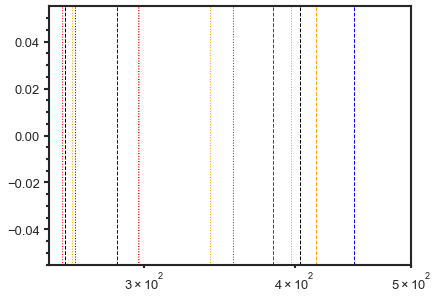

In [7]:
mdl = pd.read_csv('data/theoretical-modes.csv')
for mode in mdl.iterrows():
    color = ['black', 'blue', 'red', 'orange'][int(mode[1].l)]
    plt.axvline(mode[1].nu, ls='--' if mode[1].n_g == 0 else ':', c=color, zorder=-99, lw=1)

plt.xlim([250, 500])
plt.semilogx()

In [8]:
mdl.nu.max()

1473.015659903765

In [9]:
freqs = pd.read_table('data/BiSON-MDI.dat', sep='\s+')
#freqs.loc[freqs.l == 1, 'n'] -= 1
freqs

,n,l,nu,dnu
0,6,0,972.6150,0.0020
1,7,0,1117.9930,0.0040
2,7,1,1185.6040,0.0030
3,8,0,1263.1980,0.0050
4,8,1,1329.6350,0.0030
...,...,...,...,...
2190,0,246,1579.3769,0.0052
2191,0,247,1582.5347,0.0052
2192,0,248,1585.6919,0.0054
2193,0,249,1588.8384,0.0054


In [10]:
lowl = freqs[freqs.l <= 3]
pd.DataFrame({'l': lowl.l, 'n': lowl.n, 
              'nu': lowl.nu, 
              'dnu': lowl.dnu}).to_csv('data/bison-lowl-modes.csv')

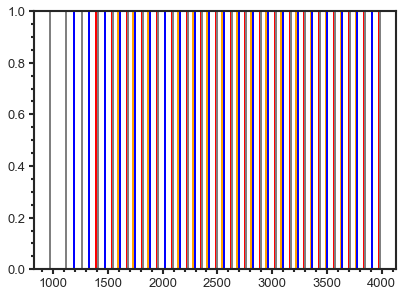

In [11]:
bison = pd.read_csv('data/bison-lowl-modes.csv')
for mode in bison.iterrows():
    color = ['gray', 'blue', 'red', 'orange'][int(mode[1].l)]
    plt.axvline(mode[1].nu, ls='-', c=color, zorder=-98)

In [12]:
bison.nu.max()

3984.214

In [13]:
for mode in freqs[freqs.l<=0].iterrows():
    print(int(mode[1].n), '%.4f'%mode[1]['nu'])

6 972.6150
7 1117.9930
8 1263.1980
9 1407.4720
10 1548.3360
11 1686.5940
12 1822.2020
13 1957.4520
14 2093.5180
15 2228.7490
16 2362.7880
17 2496.1800
18 2629.6680
19 2764.1420
20 2899.0220
21 3033.7540
22 3168.6180
23 3303.5200
24 3438.9920
25 3574.8930
26 3710.7170
27 3846.9930
28 3984.2140


In [14]:
for mode in freqs[freqs.l<=0].iterrows():
    #print(int(mode[1].n), '%.4f'%mode[1]['nu'])
    print(r"ax.axvline(" + str(mode[1]['nu']) + ", ls='--', c='lightgray', zorder=-99)")

ax.axvline(972.615, ls='--', c='lightgray', zorder=-99)
ax.axvline(1117.993, ls='--', c='lightgray', zorder=-99)
ax.axvline(1263.198, ls='--', c='lightgray', zorder=-99)
ax.axvline(1407.472, ls='--', c='lightgray', zorder=-99)
ax.axvline(1548.336, ls='--', c='lightgray', zorder=-99)
ax.axvline(1686.594, ls='--', c='lightgray', zorder=-99)
ax.axvline(1822.202, ls='--', c='lightgray', zorder=-99)
ax.axvline(1957.452, ls='--', c='lightgray', zorder=-99)
ax.axvline(2093.518, ls='--', c='lightgray', zorder=-99)
ax.axvline(2228.749, ls='--', c='lightgray', zorder=-99)
ax.axvline(2362.788, ls='--', c='lightgray', zorder=-99)
ax.axvline(2496.18, ls='--', c='lightgray', zorder=-99)
ax.axvline(2629.668, ls='--', c='lightgray', zorder=-99)
ax.axvline(2764.142, ls='--', c='lightgray', zorder=-99)
ax.axvline(2899.022, ls='--', c='lightgray', zorder=-99)
ax.axvline(3033.754, ls='--', c='lightgray', zorder=-99)
ax.axvline(3168.618, ls='--', c='lightgray', zorder=-99)
ax.axvline(3303.52, ls='--', c='l

In [15]:
freqs = freqs[freqs.nu < 2000]
freqs = freqs[freqs.l <= 5]
freqs

,n,l,nu,dnu
0,6,0,972.6150,0.0020
1,7,0,1117.9930,0.0040
2,7,1,1185.6040,0.0030
3,8,0,1263.1980,0.0050
4,8,1,1329.6350,0.0030
5,8,2,1394.6890,0.0050
6,9,0,1407.4720,0.0060
7,9,1,1472.8390,0.0060
8,9,2,1535.8530,0.0050
9,10,0,1548.3360,0.0070


/home/earl/anaconda3/lib/python3.9/site-packages/matplotlib/ticker.py:2938: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/earl/anaconda3/lib/python3.9/site-packages/matplotlib/ticker.py:2938: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


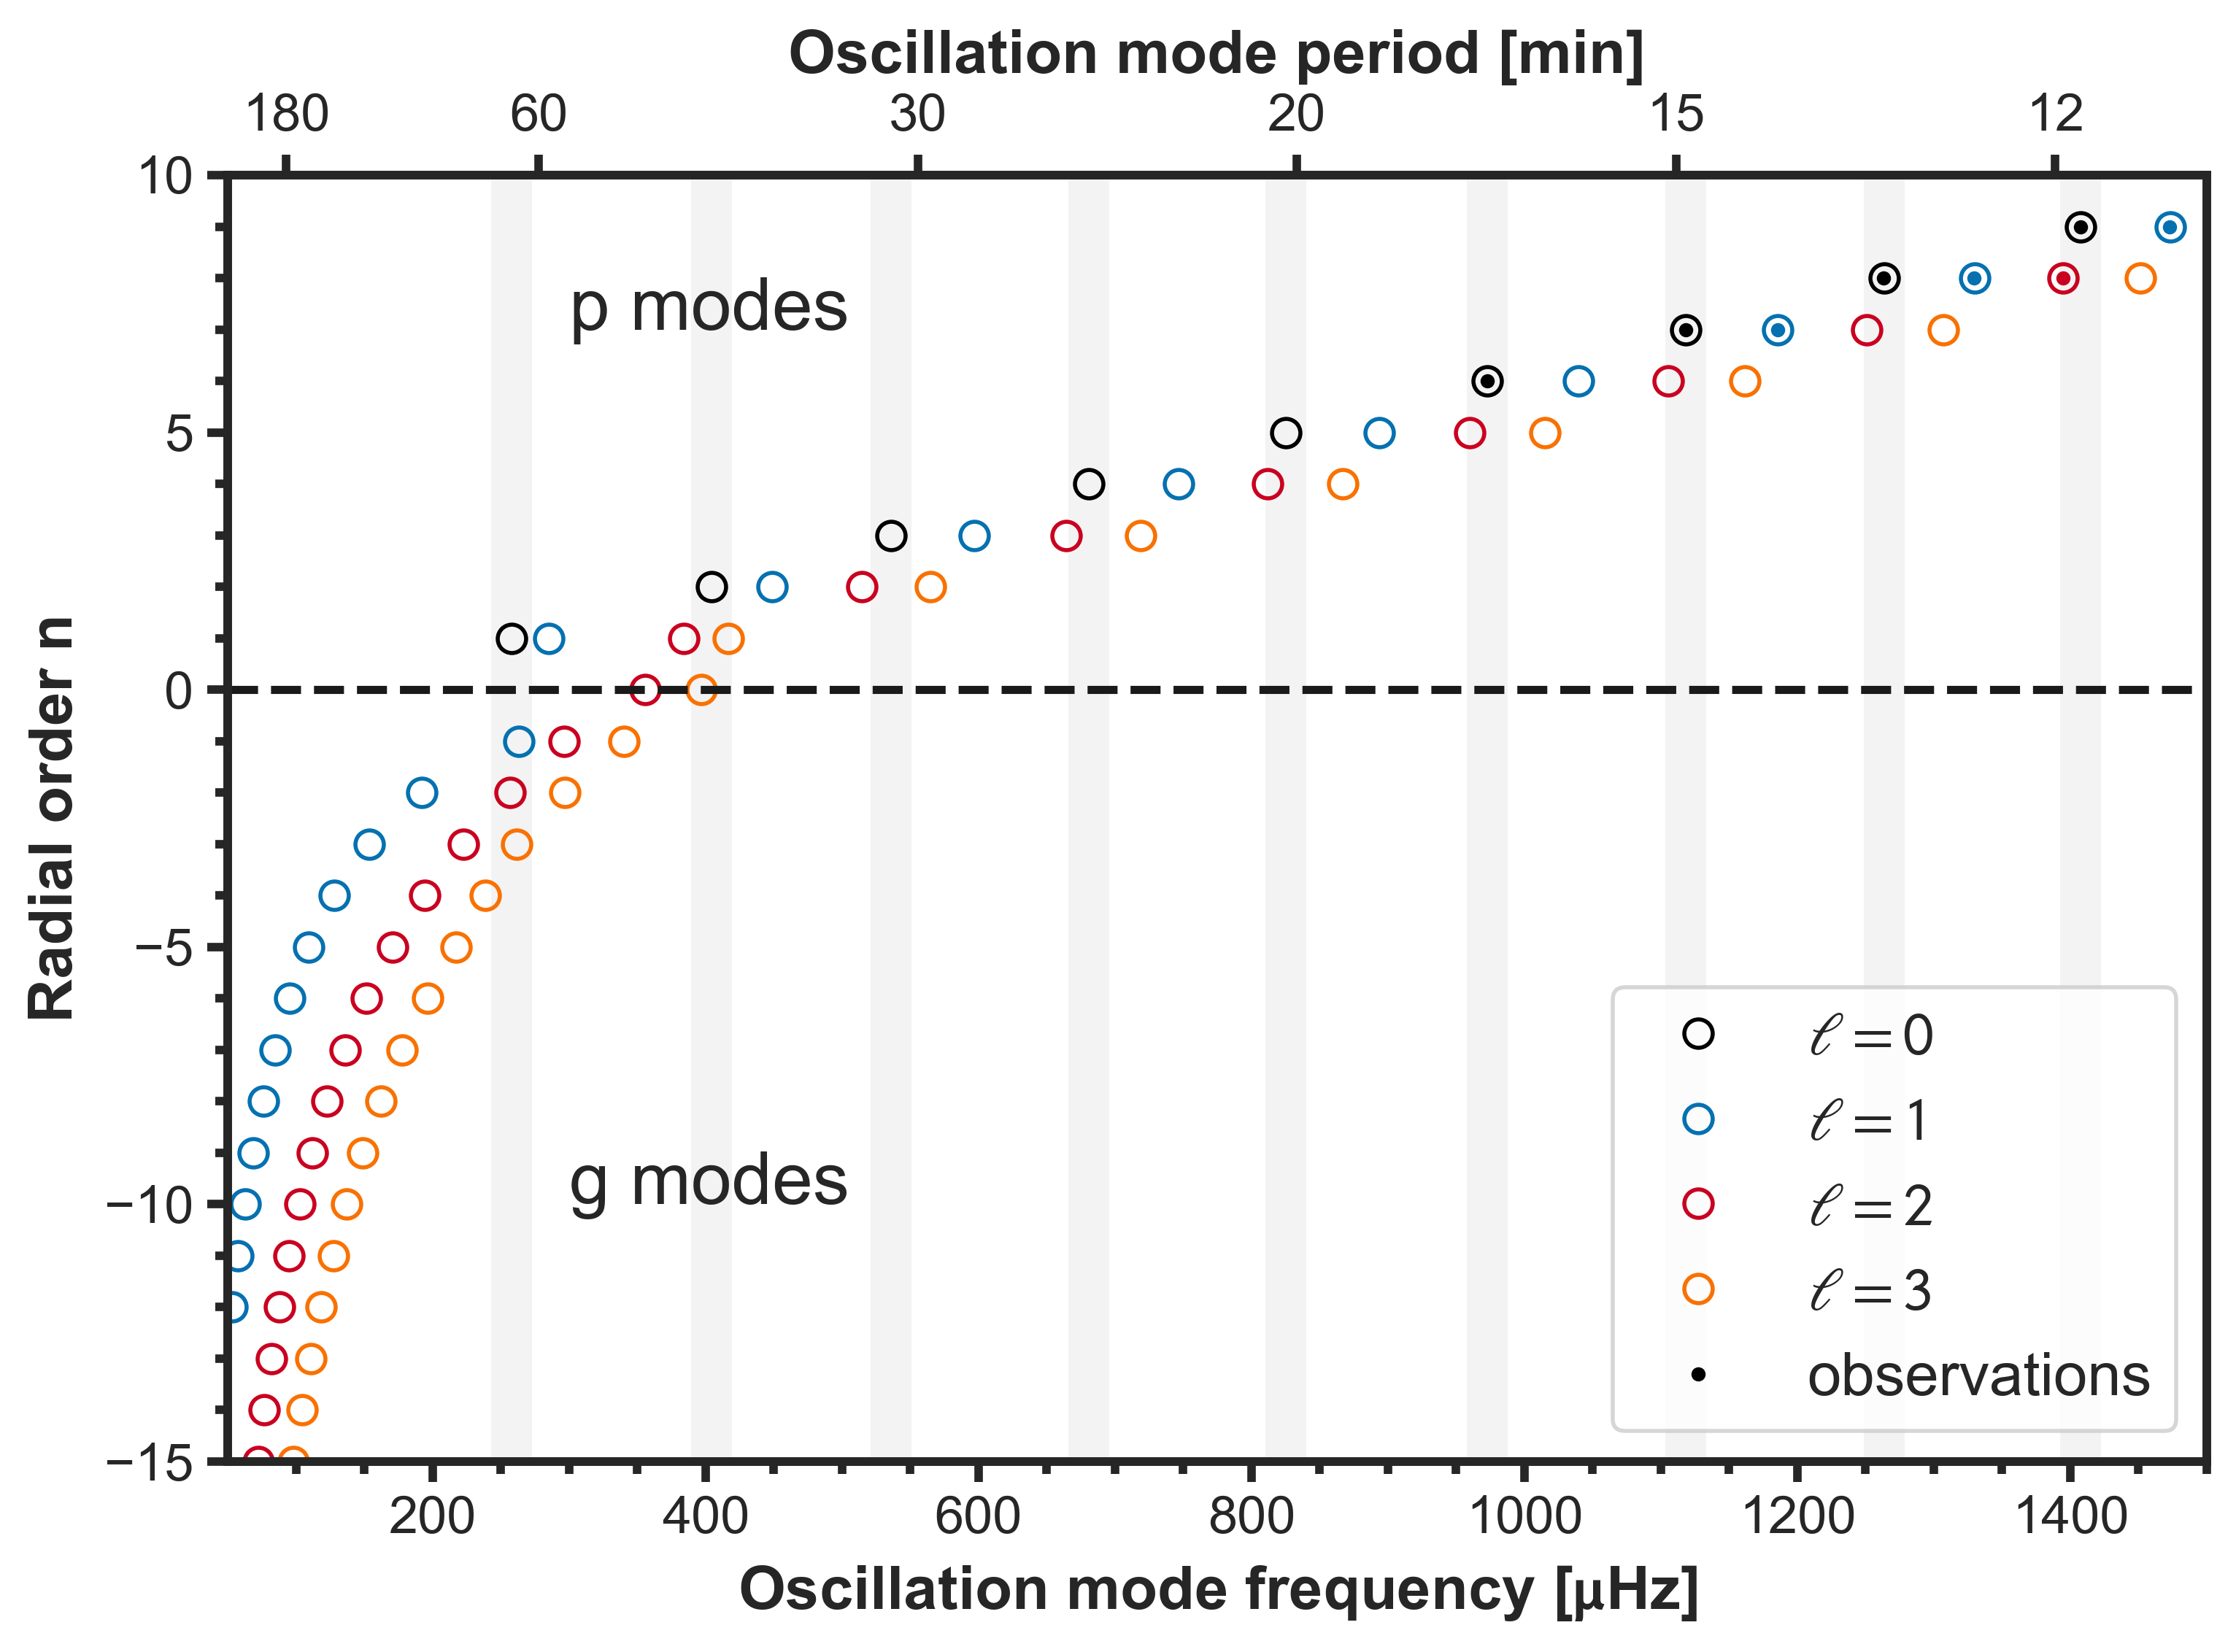

In [16]:
plt.figure(figsize=(8,6), dpi=400)

colors = ['black', blue, red, orange]

for ell in np.unique(model['l'].values):
    sph = model[model.l == ell]
    plt.plot(sph['Re(freq)'], sph['n_pg'], 
             c=colors[int(ell)], 
             marker='o', ls='None', mfc='None', ms=7,
            label=r'$\ell = %d'%int(ell)+r'$')
    
    if ell == 0:
        for mode in sph.iterrows():
            plt.axvspan(mode[1]['Re(freq)']-15, mode[1]['Re(freq)']+15, lw=0,
                        color='k', alpha=0.05, zorder=-9)

for ell in np.unique(model['l'].values):
    sph = freqs[freqs.l == ell]
    plt.plot(sph['nu'], sph['n'], 
             c=colors[int(ell)], 
             marker='.', ls='None', ms=5,
            label=r'observations' if ell<1 else '')

plt.legend()

plt.axhline(0, ls='--', c='k')
plt.text(3e2, -10, r'g modes')
plt.text(3e2, 7, r'p modes')

plt.xlim([50, 1500])
plt.ylim([-15, 10])

plt.xlabel(r'Oscillation mode frequency [$\mathbf{\mu}$Hz]')
plt.ylabel(r'Radial order n', zorder=-99)

# Add a twinned axis for the period in hrs
ax2 = plt.twiny()#plt.gca().yaxis)
#ax2.set_xlim(uHz2hr(50), uHz2hr(1500))
#xs = [50, 70, 100, 200, 900]
#ax2.set_xticks([uHz2hr(x) for x in xs])
#ax2.set_xticklabels(['%.1f'%uHz2hr(x) for x in xs])
ax2.set_xlim(50, 1500)
#Ps = [0.2, 0.3, 0.5, 1, 3]
#ax2.set_xticks([hr2uHz(x) for x in Ps])
Ps = [12, 15, 20, 30, 60, 180]
ax2.set_xticks([min2uHz(x) for x in Ps])
ax2.set_xticklabels(Ps)
ax2.set_xlabel('Oscillation mode period [min]')

plt.tight_layout()
plt.show()

In [17]:
(1/(1*1e-6*unt.Hz)).to(unt.day)/unt.day

<Quantity 11.57407407>

In [18]:
(1/(unt.day)).to(unt.Hz)/1e-6

<Quantity 11.57407407 Hz>

In [19]:
(200*1e-6*unt.Hz)

<Quantity 0.0002 Hz>

In [20]:
sph = model[model.l == 0]
for mode in sph.iterrows():
    print(int(mode[1].n_pg), '%.4f'%mode[1]['Re(freq)'])#, '%.4f'%uHz2min(mode[1]['Re(freq)']))

1 258.0473
2 404.5170
3 535.9691
4 680.5993
5 825.3916
6 972.7745
7 1118.1802
8 1263.5572
9 1407.6646
